### Single GPU Training

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.filters import threshold_otsu

# Custom Dataset Class
class FaceSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.mask_transform = mask_transform
        self.image_files = sorted(os.listdir(image_dir))
        self.mask_files = sorted(os.listdir(mask_dir))

        # Debug: Print dataset stats
        print(f"Dataset initialized with {len(self.image_files)} images and {len(self.mask_files)} masks.")
        print(f"Sample image file: {self.image_files[0]}, Sample mask file: {self.mask_files[0]}")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])
        
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')  # Convert to grayscale
        
        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
            
        # Debug: Print shapes and values
        if idx == 0:  # Print only for the first sample
            print(f"Image shape: {image.shape}, Mask shape: {mask.shape}")
            print(f"Image min/max: {image.min().item():.4f}/{image.max().item():.4f}")
            print(f"Mask unique values: {torch.unique(mask)}")
            
        return image, mask

# U-Net Model Architecture
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        
        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, 3, padding=1),
                nn.ReLU(inplace=True)
            )
        
        # Encoder
        self.enc1 = conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = conv_block(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        
        # Bottleneck
        self.bottleneck = conv_block(512, 1024)
        
        # Decoder
        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = conv_block(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = conv_block(128, 64)
        
        self.final = nn.Conv2d(64, out_channels, 1)
        
    def forward(self, x):
        # Debug: Print input shape
        print(f"Input shape to U-Net: {x.shape}") if torch.is_tensor(x) else None
        
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))
        enc3 = self.enc3(self.pool2(enc2))
        enc4 = self.enc4(self.pool3(enc3))
        
        # Bottleneck
        bottleneck = self.bottleneck(self.pool4(enc4))
        
        # Decoder
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dec4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)
        
        output = torch.sigmoid(self.final(dec1))
        
        # Debug: Print output shape
        print(f"Output shape from U-Net: {output.shape}")
        
        return output

# Metrics Calculation
def calculate_iou(pred, target):
    pred = (pred > 0.5).float()
    intersection = (pred & target).sum()
    union = (pred | target).sum()
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.item()

def calculate_dice(pred, target):
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum()
    dice = (2. * intersection + 1e-6) / (pred.sum() + target.sum() + 1e-6)
    return dice.item()

# Traditional Method (Otsu's Thresholding)
def otsu_segmentation(image_path, target_size=(256, 256)):
    image = Image.open(image_path).convert('RGB')
    image = image.resize(target_size)
    image_np = np.array(image)
    gray = np.dot(image_np[...,:3], [0.2989, 0.5870, 0.1140])
    thresh = threshold_otsu(gray)
    binary = (gray > thresh).astype(np.float32)
    return torch.from_numpy(binary)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.filters import threshold_otsu

# Custom Dataset Class
class FaceSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.mask_transform = mask_transform
        self.image_files = sorted(os.listdir(image_dir))
        self.mask_files = sorted(os.listdir(mask_dir))

        # Debug: Print dataset stats
        print(f"Dataset initialized with {len(self.image_files)} images and {len(self.mask_files)} masks.")
        print(f"Sample image file: {self.image_files[0]}, Sample mask file: {self.mask_files[0]}")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])
        
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')  # Convert to grayscale
        
        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
            
        # Debug: Print shapes and values
        if idx == 0:  # Print only for the first sample
            print(f"Image shape: {image.shape}, Mask shape: {mask.shape}")
            print(f"Image min/max: {image.min().item():.4f}/{image.max().item():.4f}")
            print(f"Mask unique values: {torch.unique(mask)}")
            
        return image, mask

# U-Net Model Architecture
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__():
        # (Your existing U-Net code here)
        pass

    def forward(self, x):
        # (Your existing forward code here)
        pass

# Metrics Calculation
def calculate_iou(pred, target):
    # (Your existing IoU code here)
    pass

def calculate_dice(pred, target):
    # (Your existing Dice code here)
    pass

# Traditional Method (Otsu's Thresholding)
def otsu_segmentation(image_path, target_size=(256, 256)):
    # (Your existing Otsu code here)
    pass

# Configuration
image_dir = '/kaggle/input/msdf-mskdataset/face_crop'
mask_dir = '/kaggle/input/msdf-mskdataset/face_crop_segmentation'
batch_size = 4
epochs = 20
lr = 0.001
patience = 5  # Early stopping patience
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Debug: Print device info
print(f"Using device: {device}")

# Transforms
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256), transforms.InterpolationMode.NEAREST),
    transforms.ToTensor()
])

# Dataset and DataLoader
dataset = FaceSegmentationDataset(image_dir, mask_dir, image_transform, mask_transform)
train_idx, val_idx = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)
train_dataset = torch.utils.data.Subset(dataset, train_idx)
val_dataset = torch.utils.data.Subset(dataset, val_idx)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Debug: Print dataset split info
print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")

# Model, Loss, Optimizer
model = UNet().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Debug: Print model summary
print(model)

# Checkpoint Configuration
checkpoint_dir = '/kaggle/working/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)  # Create directory if it doesn't exist
checkpoint_interval = 5  # Save checkpoint every 5 epochs

# Function to save checkpoint
def save_checkpoint(epoch, model, optimizer, loss, path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, path)
    print(f"Checkpoint saved to {path}")

# Function to load checkpoint
def load_checkpoint(path, model, optimizer):
    if os.path.exists(path):
        checkpoint = torch.load(path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        loss = checkpoint['loss']
        print(f"Checkpoint loaded from {path}. Resuming from epoch {epoch + 1}")
        return epoch + 1  # Resume from the next epoch
    else:
        print("No checkpoint found. Starting from scratch.")
        return 0  # Start from epoch 0

# Load the latest checkpoint if it exists
latest_checkpoint = None
for epoch in range(epochs):
    if epoch % checkpoint_interval == 0:  # Check if it's time to save a checkpoint
        checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch}.pth')
        if os.path.exists(checkpoint_path):
            latest_checkpoint = checkpoint_path

if latest_checkpoint:
    start_epoch = load_checkpoint(latest_checkpoint, model, optimizer)
else:
    start_epoch = 0

# Training Loop
print("Starting training...")
for epoch in range(start_epoch, epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (images, masks) in enumerate(train_loader):
        images = images.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        
        # Debug: Print batch stats
        if batch_idx % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")
    
    epoch_loss = running_loss / len(train_dataset)
    print(f'Epoch [{epoch+1}/{epochs}], Average Loss: {epoch_loss:.4f}')

    # Save checkpoint every 5 epochs
    if (epoch + 1) % checkpoint_interval == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch + 1}.pth')
        save_checkpoint(epoch + 1, model, optimizer, epoch_loss, checkpoint_path)
    
    # Calculate validation loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, masks).item() * images.size(0)
    
    val_loss /= len(val_dataset)
    print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {running_loss / len(train_dataset):.4f}, Validation Loss: {val_loss:.4f}')

    # Early Stopping and Model Saving
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"Validation loss improved. Saving best model to {best_model_path}")
    else:
        early_stopping_counter += 1
        print(f"Validation loss did not improve. Patience: {early_stopping_counter}/{patience}")
        if early_stopping_counter >= patience:
            print("Early stopping triggered.")
            break

# Save the final model
torch.save(model.state_dict(), final_model_path)
print(f"Final model saved to {final_model_path}")

# Evaluation
model.eval()
total_iou, total_dice = 0.0, 0.0
with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(device)
        masks = masks.to(device)
        outputs = model(images)
        
        for i in range(outputs.shape[0]):
            iou = calculate_iou(outputs[i], masks[i])
            dice = calculate_dice(outputs[i], masks[i])
            total_iou += iou
            total_dice += dice
            
            # Debug: Print sample metrics
            if i == 0:  # Print for the first sample in each batch
                print(f"Sample IoU: {iou:.4f}, Sample Dice: {dice:.4f}")

avg_iou = total_iou / len(val_dataset)
avg_dice = total_dice / len(val_dataset)
print(f'\nU-Net Performance:')
print(f'Average IoU: {avg_iou:.4f}')
print(f'Average Dice: {avg_dice:.4f}')

# Traditional Method Evaluation
print("\nEvaluating traditional method...")
total_iou_trad, total_dice_trad = 0.0, 0.0
for idx in val_idx:
    image_path = os.path.join(image_dir, dataset.image_files[idx])
    true_mask = dataset[idx][1].squeeze()
    
    pred_mask = otsu_segmentation(image_path).float()
    pred_mask = (pred_mask > 0.5).float()
    
    iou_trad = calculate_iou(pred_mask, true_mask)
    dice_trad = calculate_dice(pred_mask, true_mask)
    total_iou_trad += iou_trad
    total_dice_trad += dice_trad
    
    # Debug: Print sample metrics
    if idx % 10 == 0:  # Print every 10th sample
        print(f"Sample {idx}: Traditional IoU: {iou_trad:.4f}, Dice: {dice_trad:.4f}")

avg_iou_trad = total_iou_trad / len(val_dataset)
avg_dice_trad = total_dice_trad / len(val_dataset)
print(f'Traditional Method Performance:')
print(f'Average IoU: {avg_iou_trad:.4f}')
print(f'Average Dice: {avg_dice_trad:.4f}')

Using device: cuda
Dataset initialized with 9383 images and 9383 masks.
Sample image file: 000000_1.jpg, Sample mask file: 000000_1.jpg
Training samples: 7506, Validation samples: 1877
UNet(
  (enc1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3)

### Dual GPU Training

### Model Arch - 1 section

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.filters import threshold_otsu


#### DataSet Class

In [ ]:
# Custom Dataset Class
class FaceSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.mask_transform = mask_transform
        self.image_files = sorted(os.listdir(image_dir))
        self.mask_files = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])
        
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')
        
        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
            
        return image, mask

#### U-Net Architecture

In [ ]:
# Fixed U-Net Architecture - Now removing the sigmoid from the model
class FastUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(FastUNet, self).__init__()
        
        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, 3, padding=1),
                nn.ReLU(inplace=True)
            )
        
        # Reduced number of filters
        self.enc1 = conv_block(in_channels, 32)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = conv_block(32, 64)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = conv_block(64, 128)
        self.pool3 = nn.MaxPool2d(2)
        
        self.bottleneck = conv_block(128, 256)
        
        self.upconv3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec3 = conv_block(256, 128)  # 256 = 128 (from upconv3) + 128 (from enc3)
        
        self.upconv2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec2 = conv_block(128, 64)   # 128 = 64 (from upconv2) + 64 (from enc2)
        
        self.upconv1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec1 = conv_block(64, 32)    # 64 = 32 (from upconv1) + 32 (from enc1)
        
        self.final = nn.Conv2d(32, out_channels, 1)
        
    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))
        enc3 = self.enc3(self.pool2(enc2))
        
        # Bottleneck
        bottleneck = self.bottleneck(self.pool3(enc3))
        
        # Decoder - Complete decoder path with all upsampling steps
        dec3 = self.upconv3(bottleneck)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)
        
        # Removed sigmoid to use with BCEWithLogitsLoss
        return self.final(dec1)


### Model Arch - 2 

#### Module imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms
from PIL import Image
import os
import numpy as np
from sklearn.model_selection import KFold
from skimage.filters import threshold_otsu

In [2]:


# Custom Dataset Class
class FaceSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.mask_transform = mask_transform
        self.image_files = sorted(os.listdir(image_dir))
        self.mask_files = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])
        
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')
        
        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
            
        return image, mask

# Attention Gate Module
class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l):
        super(AttentionGate, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_l, 1),
            nn.BatchNorm2d(F_l)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_l, 1),
            nn.BatchNorm2d(F_l)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_l, 1, 1),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

# Enhanced U-Net Architecture
class EnhancedUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(EnhancedUNet, self).__init__()
        
        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, 3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

        # Encoder
        self.enc1 = conv_block(in_channels, 48)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = conv_block(48, 96)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = conv_block(96, 192)
        self.pool3 = nn.MaxPool2d(2)
        
        # Bottleneck
        self.bottleneck = conv_block(192, 384)
        
        # Decoder with Attention Gates
        self.upconv3 = nn.ConvTranspose2d(384, 192, 2, stride=2)
        self.attn3 = AttentionGate(192, 192)
        self.dec3 = conv_block(384, 192)
        
        self.upconv2 = nn.ConvTranspose2d(192, 96, 2, stride=2)
        self.attn2 = AttentionGate(96, 96)
        self.dec2 = conv_block(192, 96)
        
        self.upconv1 = nn.ConvTranspose2d(96, 48, 2, stride=2)
        self.attn1 = AttentionGate(48, 48)
        self.dec1 = conv_block(96, 48)
        
        self.final = nn.Conv2d(48, out_channels, 1)
        
        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))
        enc3 = self.enc3(self.pool2(enc2))
        
        # Bottleneck
        bottleneck = self.bottleneck(self.pool3(enc3))
        
        # Decoder
        dec3 = self.upconv3(bottleneck)
        dec3 = self.attn3(dec3, enc3)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = self.attn2(dec2, enc2)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = self.attn1(dec1, enc1)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)
        
        return self.final(dec1)

# Combined Loss Function
class CombinedLoss(nn.Module):
    def __init__(self, bce_weight=0.7):
        super().__init__()
        self.bce_weight = bce_weight
        self.bce = nn.BCEWithLogitsLoss()
        
    def dice_loss(self, pred, target):
        smooth = 1.
        pred = torch.sigmoid(pred)
        intersection = (pred * target).sum()
        return 1 - (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
        
    def forward(self, pred, target):
        return self.bce_weight * self.bce(pred, target) + \
               (1 - self.bce_weight) * self.dice_loss(pred, target)

# Configuration
image_dir = '/kaggle/input/msdf-mskdataset/face_crop'
mask_dir = '/kaggle/input/msdf-mskdataset/face_crop_segmentation'
batch_size = 32
input_size = 128
epochs = 30
lr = 0.001
patience = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint_dir = '/kaggle/working/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
k_folds = 3

# Data Augmentation
image_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

mask_transform = transforms.Compose([
    transforms.Resize((input_size, input_size), transforms.InterpolationMode.NEAREST),
    transforms.ToTensor()
])

# Metrics Calculation
def calculate_metrics(pred, target):
    pred = torch.sigmoid(pred)
    pred_bin = (pred > 0.5).float()
    
    # IoU
    intersection = (pred_bin * target).sum()
    union = pred_bin.sum() + target.sum() - intersection
    iou = (intersection + 1e-6) / (union + 1e-6)
    
    # Dice
    dice = (2. * intersection + 1e-6) / (pred_bin.sum() + target.sum() + 1e-6)
    
    return iou.item(), dice.item()

# Traditional Method
def otsu_segmentation(image_path, target_size=(128, 128)):
    image = Image.open(image_path).convert('L')
    image = image.resize(target_size)
    img_array = np.array(image)
    threshold = threshold_otsu(img_array)
    binary = torch.tensor(img_array > threshold).float()
    return binary.unsqueeze(0)

# Initialize dataset
dataset = FaceSegmentationDataset(image_dir, mask_dir, image_transform, mask_transform)
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Training and Evaluation
final_metrics = {'unet': {'iou': [], 'dice': []}, 'traditional': {'iou': [], 'dice': []}}

for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
    print(f'\n{"="*30}\nFold {fold+1}/{k_folds}\n{"="*30}')
    
    # Data loaders
    train_subsampler = SubsetRandomSampler(train_ids)
    val_subsampler = SubsetRandomSampler(val_ids)
    
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_subsampler,
                            pin_memory=True, num_workers=4, persistent_workers=True)
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_subsampler,
                          pin_memory=True, num_workers=4, persistent_workers=True)

    # Model setup
    model = EnhancedUNet().to(device)
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
    
    criterion = CombinedLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)
    
    best_val_loss = float('inf')
    early_stop_counter = 0
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        
        # Training phase
        for images, masks in train_loader:
            images = images.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_iou, val_dice = 0.0, 0.0
        
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)
                outputs = model(images)
                
                loss = criterion(outputs, masks)
                val_loss += loss.item()
                
                iou, dice = calculate_metrics(outputs, masks)
                val_iou += iou * images.size(0)
                val_dice += dice * images.size(0)
        
        # Calculate metrics
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        val_iou /= len(val_ids)
        val_dice /= len(val_ids)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
            torch.save(model.state_dict(), f'{checkpoint_dir}/best_fold{fold+1}.pth')
        else:
            early_stop_counter += 1
            
        # Print epoch summary
        print(f'Epoch {epoch+1:02d}/{epochs} | '
              f'Train Loss: {train_loss:.4f} | '
              f'Val Loss: {val_loss:.4f} | '
              f'IoU: {val_iou:.4f} | '
              f'Dice: {val_dice:.4f} | '
              f'LR: {optimizer.param_groups[0]["lr"]:.2e}')
        
        # Early stopping
        if early_stop_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break
    
    # Load best model for evaluation
    model.load_state_dict(torch.load(f'{checkpoint_dir}/best_fold{fold+1}.pth'))
    
    # Final evaluation
    model.eval()
    fold_iou, fold_dice = 0.0, 0.0
    trad_iou, trad_dice = 0.0, 0.0
    
    with torch.no_grad():
        for idx in val_ids:
            # U-Net evaluation
            image, mask = dataset[idx]
            image = image.unsqueeze(0).to(device)
            pred = model(image)
            iou, dice = calculate_metrics(pred, mask.unsqueeze(0).to(device))
            fold_iou += iou
            fold_dice += dice
            
            # Traditional method evaluation
            img_path = os.path.join(image_dir, dataset.image_files[idx])
            true_mask = mask.squeeze().cpu()
            pred_mask = otsu_segmentation(img_path)
            trad_iou += calculate_metrics(torch.tensor(pred_mask).unsqueeze(0), true_mask.unsqueeze(0))[0]
            trad_dice += calculate_metrics(torch.tensor(pred_mask).unsqueeze(0), true_mask.unsqueeze(0))[1]
    
    # Store metrics
    final_metrics['unet']['iou'].append(fold_iou/len(val_ids))
    final_metrics['unet']['dice'].append(fold_dice/len(val_ids))
    final_metrics['traditional']['iou'].append(trad_iou/len(val_ids))
    final_metrics['traditional']['dice'].append(trad_dice/len(val_ids))
    
    print(f'\nFold {fold+1} Results:')
    print(f'U-Net:    IoU: {final_metrics["unet"]["iou"][-1]:.4f} | Dice: {final_metrics["unet"]["dice"][-1]:.4f}')
    print(f'Traditional: IoU: {final_metrics["traditional"]["iou"][-1]:.4f} | Dice: {final_metrics["traditional"]["dice"][-1]:.4f}')

# Final Summary
print('\n\nFinal Cross-Validation Results:')
print('U-Net Performance:')
print(f'Mean IoU: {np.mean(final_metrics["unet"]["iou"]):.4f} (±{np.std(final_metrics["unet"]["iou"]):.4f})')
print(f'Mean Dice: {np.mean(final_metrics["unet"]["dice"]):.4f} (±{np.std(final_metrics["unet"]["dice"]):.4f})')

print('\nTraditional Method Performance:')
print(f'Mean IoU: {np.mean(final_metrics["traditional"]["iou"]):.4f} (±{np.std(final_metrics["traditional"]["iou"]):.4f})')
print(f'Mean Dice: {np.mean(final_metrics["traditional"]["dice"]):.4f} (±{np.std(final_metrics["traditional"]["dice"]):.4f})')


Fold 1/3
Epoch 01/30 | Train Loss: 0.4688 | Val Loss: 0.3202 | IoU: 0.6366 | Dice: 0.7777 | LR: 1.00e-03
Epoch 02/30 | Train Loss: 0.3102 | Val Loss: 0.3016 | IoU: 0.6635 | Dice: 0.7975 | LR: 1.00e-03
Epoch 03/30 | Train Loss: 0.2944 | Val Loss: 0.2971 | IoU: 0.6533 | Dice: 0.7901 | LR: 1.00e-03
Epoch 04/30 | Train Loss: 0.2887 | Val Loss: 0.2833 | IoU: 0.6755 | Dice: 0.8061 | LR: 1.00e-03
Epoch 05/30 | Train Loss: 0.2854 | Val Loss: 0.2849 | IoU: 0.6745 | Dice: 0.8053 | LR: 1.00e-03
Epoch 06/30 | Train Loss: 0.2810 | Val Loss: 0.2852 | IoU: 0.6646 | Dice: 0.7983 | LR: 1.00e-03
Epoch 07/30 | Train Loss: 0.2787 | Val Loss: 0.2780 | IoU: 0.6754 | Dice: 0.8061 | LR: 1.00e-03
Epoch 08/30 | Train Loss: 0.2773 | Val Loss: 0.2796 | IoU: 0.6764 | Dice: 0.8067 | LR: 1.00e-03
Epoch 09/30 | Train Loss: 0.2776 | Val Loss: 0.2773 | IoU: 0.6791 | Dice: 0.8087 | LR: 1.00e-03
Epoch 10/30 | Train Loss: 0.2746 | Val Loss: 0.2758 | IoU: 0.6803 | Dice: 0.8095 | LR: 1.00e-03
Epoch 11/30 | Train Loss: 0.27

<ipython-input-2-ed62b66c3c23>:307: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{checkpoint_dir}/best_fold{fold+1}.pth'))
<ipython-input


Fold 1 Results:
U-Net:    IoU: 0.6894 | Dice: 0.8079
Traditional: IoU: 0.2597 | Dice: 0.3849

Fold 2/3
Epoch 01/30 | Train Loss: 0.5241 | Val Loss: 0.3294 | IoU: 0.6315 | Dice: 0.7740 | LR: 1.00e-03
Epoch 02/30 | Train Loss: 0.3144 | Val Loss: 0.3046 | IoU: 0.6581 | Dice: 0.7936 | LR: 1.00e-03
Epoch 03/30 | Train Loss: 0.2965 | Val Loss: 0.2944 | IoU: 0.6632 | Dice: 0.7973 | LR: 1.00e-03
Epoch 04/30 | Train Loss: 0.2909 | Val Loss: 0.3027 | IoU: 0.6547 | Dice: 0.7911 | LR: 1.00e-03
Epoch 05/30 | Train Loss: 0.2852 | Val Loss: 0.2787 | IoU: 0.6787 | Dice: 0.8084 | LR: 1.00e-03
Epoch 06/30 | Train Loss: 0.2833 | Val Loss: 0.2768 | IoU: 0.6798 | Dice: 0.8092 | LR: 1.00e-03
Epoch 07/30 | Train Loss: 0.2805 | Val Loss: 0.2797 | IoU: 0.6728 | Dice: 0.8042 | LR: 1.00e-03
Epoch 08/30 | Train Loss: 0.2789 | Val Loss: 0.2758 | IoU: 0.6784 | Dice: 0.8082 | LR: 1.00e-03
Epoch 09/30 | Train Loss: 0.2771 | Val Loss: 0.2821 | IoU: 0.6710 | Dice: 0.8029 | LR: 1.00e-03
Epoch 10/30 | Train Loss: 0.2767

In [3]:
# Save the best model from each fold
for fold in range(k_folds):
    model_path = f'{checkpoint_dir}/best_fold{fold+1}.pth'
    print(f'Saved best model for fold {fold+1} at: {model_path}')

# Optionally: Save an averaged model (ensemble of all folds)
if k_folds > 1:
    # Load all fold models
    models = []
    for fold in range(k_folds):
        model = EnhancedUNet().to(device)
        model.load_state_dict(torch.load(f'{checkpoint_dir}/best_fold{fold+1}.pth'))
        models.append(model)
    
    # Average model weights
    averaged_state_dict = {}
    for key in models[0].state_dict().keys():
        averaged_state_dict[key] = torch.mean(
            torch.stack([model.state_dict()[key] for model in models]), dim=0
        )
    
    # Save the averaged model
    averaged_model = EnhancedUNet().to(device)
    averaged_model.load_state_dict(averaged_state_dict)
    torch.save(averaged_model.state_dict(), f'{checkpoint_dir}/averaged_model.pth')
    print(f'Saved averaged model at: {checkpoint_dir}/averaged_model.pth')

Saved best model for fold 1 at: /kaggle/working/checkpoints/best_fold1.pth
Saved best model for fold 2 at: /kaggle/working/checkpoints/best_fold2.pth
Saved best model for fold 3 at: /kaggle/working/checkpoints/best_fold3.pth


<ipython-input-3-704bd7509028>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{checkpoint_dir}/best_fold{fold+1}.pth'))


RuntimeError: Error(s) in loading state_dict for EnhancedUNet:
	Missing key(s) in state_dict: "enc1.0.weight", "enc1.0.bias", "enc1.1.weight", "enc1.1.bias", "enc1.1.running_mean", "enc1.1.running_var", "enc1.3.weight", "enc1.3.bias", "enc1.4.weight", "enc1.4.bias", "enc1.4.running_mean", "enc1.4.running_var", "enc2.0.weight", "enc2.0.bias", "enc2.1.weight", "enc2.1.bias", "enc2.1.running_mean", "enc2.1.running_var", "enc2.3.weight", "enc2.3.bias", "enc2.4.weight", "enc2.4.bias", "enc2.4.running_mean", "enc2.4.running_var", "enc3.0.weight", "enc3.0.bias", "enc3.1.weight", "enc3.1.bias", "enc3.1.running_mean", "enc3.1.running_var", "enc3.3.weight", "enc3.3.bias", "enc3.4.weight", "enc3.4.bias", "enc3.4.running_mean", "enc3.4.running_var", "bottleneck.0.weight", "bottleneck.0.bias", "bottleneck.1.weight", "bottleneck.1.bias", "bottleneck.1.running_mean", "bottleneck.1.running_var", "bottleneck.3.weight", "bottleneck.3.bias", "bottleneck.4.weight", "bottleneck.4.bias", "bottleneck.4.running_mean", "bottleneck.4.running_var", "upconv3.weight", "upconv3.bias", "attn3.W_g.0.weight", "attn3.W_g.0.bias", "attn3.W_g.1.weight", "attn3.W_g.1.bias", "attn3.W_g.1.running_mean", "attn3.W_g.1.running_var", "attn3.W_x.0.weight", "attn3.W_x.0.bias", "attn3.W_x.1.weight", "attn3.W_x.1.bias", "attn3.W_x.1.running_mean", "attn3.W_x.1.running_var", "attn3.psi.0.weight", "attn3.psi.0.bias", "attn3.psi.1.weight", "attn3.psi.1.bias", "attn3.psi.1.running_mean", "attn3.psi.1.running_var", "dec3.0.weight", "dec3.0.bias", "dec3.1.weight", "dec3.1.bias", "dec3.1.running_mean", "dec3.1.running_var", "dec3.3.weight", "dec3.3.bias", "dec3.4.weight", "dec3.4.bias", "dec3.4.running_mean", "dec3.4.running_var", "upconv2.weight", "upconv2.bias", "attn2.W_g.0.weight", "attn2.W_g.0.bias", "attn2.W_g.1.weight", "attn2.W_g.1.bias", "attn2.W_g.1.running_mean", "attn2.W_g.1.running_var", "attn2.W_x.0.weight", "attn2.W_x.0.bias", "attn2.W_x.1.weight", "attn2.W_x.1.bias", "attn2.W_x.1.running_mean", "attn2.W_x.1.running_var", "attn2.psi.0.weight", "attn2.psi.0.bias", "attn2.psi.1.weight", "attn2.psi.1.bias", "attn2.psi.1.running_mean", "attn2.psi.1.running_var", "dec2.0.weight", "dec2.0.bias", "dec2.1.weight", "dec2.1.bias", "dec2.1.running_mean", "dec2.1.running_var", "dec2.3.weight", "dec2.3.bias", "dec2.4.weight", "dec2.4.bias", "dec2.4.running_mean", "dec2.4.running_var", "upconv1.weight", "upconv1.bias", "attn1.W_g.0.weight", "attn1.W_g.0.bias", "attn1.W_g.1.weight", "attn1.W_g.1.bias", "attn1.W_g.1.running_mean", "attn1.W_g.1.running_var", "attn1.W_x.0.weight", "attn1.W_x.0.bias", "attn1.W_x.1.weight", "attn1.W_x.1.bias", "attn1.W_x.1.running_mean", "attn1.W_x.1.running_var", "attn1.psi.0.weight", "attn1.psi.0.bias", "attn1.psi.1.weight", "attn1.psi.1.bias", "attn1.psi.1.running_mean", "attn1.psi.1.running_var", "dec1.0.weight", "dec1.0.bias", "dec1.1.weight", "dec1.1.bias", "dec1.1.running_mean", "dec1.1.running_var", "dec1.3.weight", "dec1.3.bias", "dec1.4.weight", "dec1.4.bias", "dec1.4.running_mean", "dec1.4.running_var", "final.weight", "final.bias". 
	Unexpected key(s) in state_dict: "module.enc1.0.weight", "module.enc1.0.bias", "module.enc1.1.weight", "module.enc1.1.bias", "module.enc1.1.running_mean", "module.enc1.1.running_var", "module.enc1.1.num_batches_tracked", "module.enc1.3.weight", "module.enc1.3.bias", "module.enc1.4.weight", "module.enc1.4.bias", "module.enc1.4.running_mean", "module.enc1.4.running_var", "module.enc1.4.num_batches_tracked", "module.enc2.0.weight", "module.enc2.0.bias", "module.enc2.1.weight", "module.enc2.1.bias", "module.enc2.1.running_mean", "module.enc2.1.running_var", "module.enc2.1.num_batches_tracked", "module.enc2.3.weight", "module.enc2.3.bias", "module.enc2.4.weight", "module.enc2.4.bias", "module.enc2.4.running_mean", "module.enc2.4.running_var", "module.enc2.4.num_batches_tracked", "module.enc3.0.weight", "module.enc3.0.bias", "module.enc3.1.weight", "module.enc3.1.bias", "module.enc3.1.running_mean", "module.enc3.1.running_var", "module.enc3.1.num_batches_tracked", "module.enc3.3.weight", "module.enc3.3.bias", "module.enc3.4.weight", "module.enc3.4.bias", "module.enc3.4.running_mean", "module.enc3.4.running_var", "module.enc3.4.num_batches_tracked", "module.bottleneck.0.weight", "module.bottleneck.0.bias", "module.bottleneck.1.weight", "module.bottleneck.1.bias", "module.bottleneck.1.running_mean", "module.bottleneck.1.running_var", "module.bottleneck.1.num_batches_tracked", "module.bottleneck.3.weight", "module.bottleneck.3.bias", "module.bottleneck.4.weight", "module.bottleneck.4.bias", "module.bottleneck.4.running_mean", "module.bottleneck.4.running_var", "module.bottleneck.4.num_batches_tracked", "module.upconv3.weight", "module.upconv3.bias", "module.attn3.W_g.0.weight", "module.attn3.W_g.0.bias", "module.attn3.W_g.1.weight", "module.attn3.W_g.1.bias", "module.attn3.W_g.1.running_mean", "module.attn3.W_g.1.running_var", "module.attn3.W_g.1.num_batches_tracked", "module.attn3.W_x.0.weight", "module.attn3.W_x.0.bias", "module.attn3.W_x.1.weight", "module.attn3.W_x.1.bias", "module.attn3.W_x.1.running_mean", "module.attn3.W_x.1.running_var", "module.attn3.W_x.1.num_batches_tracked", "module.attn3.psi.0.weight", "module.attn3.psi.0.bias", "module.attn3.psi.1.weight", "module.attn3.psi.1.bias", "module.attn3.psi.1.running_mean", "module.attn3.psi.1.running_var", "module.attn3.psi.1.num_batches_tracked", "module.dec3.0.weight", "module.dec3.0.bias", "module.dec3.1.weight", "module.dec3.1.bias", "module.dec3.1.running_mean", "module.dec3.1.running_var", "module.dec3.1.num_batches_tracked", "module.dec3.3.weight", "module.dec3.3.bias", "module.dec3.4.weight", "module.dec3.4.bias", "module.dec3.4.running_mean", "module.dec3.4.running_var", "module.dec3.4.num_batches_tracked", "module.upconv2.weight", "module.upconv2.bias", "module.attn2.W_g.0.weight", "module.attn2.W_g.0.bias", "module.attn2.W_g.1.weight", "module.attn2.W_g.1.bias", "module.attn2.W_g.1.running_mean", "module.attn2.W_g.1.running_var", "module.attn2.W_g.1.num_batches_tracked", "module.attn2.W_x.0.weight", "module.attn2.W_x.0.bias", "module.attn2.W_x.1.weight", "module.attn2.W_x.1.bias", "module.attn2.W_x.1.running_mean", "module.attn2.W_x.1.running_var", "module.attn2.W_x.1.num_batches_tracked", "module.attn2.psi.0.weight", "module.attn2.psi.0.bias", "module.attn2.psi.1.weight", "module.attn2.psi.1.bias", "module.attn2.psi.1.running_mean", "module.attn2.psi.1.running_var", "module.attn2.psi.1.num_batches_tracked", "module.dec2.0.weight", "module.dec2.0.bias", "module.dec2.1.weight", "module.dec2.1.bias", "module.dec2.1.running_mean", "module.dec2.1.running_var", "module.dec2.1.num_batches_tracked", "module.dec2.3.weight", "module.dec2.3.bias", "module.dec2.4.weight", "module.dec2.4.bias", "module.dec2.4.running_mean", "module.dec2.4.running_var", "module.dec2.4.num_batches_tracked", "module.upconv1.weight", "module.upconv1.bias", "module.attn1.W_g.0.weight", "module.attn1.W_g.0.bias", "module.attn1.W_g.1.weight", "module.attn1.W_g.1.bias", "module.attn1.W_g.1.running_mean", "module.attn1.W_g.1.running_var", "module.attn1.W_g.1.num_batches_tracked", "module.attn1.W_x.0.weight", "module.attn1.W_x.0.bias", "module.attn1.W_x.1.weight", "module.attn1.W_x.1.bias", "module.attn1.W_x.1.running_mean", "module.attn1.W_x.1.running_var", "module.attn1.W_x.1.num_batches_tracked", "module.attn1.psi.0.weight", "module.attn1.psi.0.bias", "module.attn1.psi.1.weight", "module.attn1.psi.1.bias", "module.attn1.psi.1.running_mean", "module.attn1.psi.1.running_var", "module.attn1.psi.1.num_batches_tracked", "module.dec1.0.weight", "module.dec1.0.bias", "module.dec1.1.weight", "module.dec1.1.bias", "module.dec1.1.running_mean", "module.dec1.1.running_var", "module.dec1.1.num_batches_tracked", "module.dec1.3.weight", "module.dec1.3.bias", "module.dec1.4.weight", "module.dec1.4.bias", "module.dec1.4.running_mean", "module.dec1.4.running_var", "module.dec1.4.num_batches_tracked", "module.final.weight", "module.final.bias". 

### Model Evaluation and training Section

#### Calculation of IOU and Dice Scores for evaluation

In [ ]:
# Function to calculate IoU and Dice scores
def calculate_iou(pred, target):
    pred_binary = (torch.sigmoid(pred) > 0.5).float()  # Apply sigmoid for predictions
    intersection = (pred_binary * target).sum()
    union = pred_binary.sum() + target.sum() - intersection
    return (intersection + 1e-6) / (union + 1e-6)

def calculate_dice(pred, target):
    pred_binary = (torch.sigmoid(pred) > 0.5).float()  # Apply sigmoid for predictions
    intersection = (pred_binary * target).sum()
    return (2.0 * intersection + 1e-6) / (pred_binary.sum() + target.sum() + 1e-6)

#### OTSU segmentation

In [ ]:

# Otsu segmentation function
def otsu_segmentation(image_path):
    image = Image.open(image_path).convert('L')
    image = image.resize((128, 128))
    img_array = np.array(image)
    threshold = threshold_otsu(img_array)
    binary = torch.tensor(img_array > threshold).float()
    return binary.unsqueeze(0)  # Add channel dimension

#### Set up the path config

In [ ]:
# Configuration
image_dir = '/kaggle/input/msdf-mskdataset/face_crop'
mask_dir = '/kaggle/input/msdf-mskdataset/face_crop_segmentation'
batch_size = 32  # Increased batch size
input_size = 128  # Reduced from 256
epochs = 20
lr = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint_interval = 5
patience = 5
best_val_loss = float('inf')
early_stopping_counter = 0
checkpoint_dir = '/kaggle/working/'

# Enable cuDNN benchmarking
torch.backends.cudnn.benchmark = True

# Transforms with reduced size
image_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

mask_transform = transforms.Compose([
    transforms.Resize((input_size, input_size), transforms.InterpolationMode.NEAREST),
    transforms.ToTensor()
])

# Function to save checkpoint
def save_checkpoint(epoch, model, optimizer, loss, path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, path)
    print(f"Checkpoint saved at {path}")

#### Training and Validation

In [ ]:
# Dataset and DataLoader with optimized settings
dataset = FaceSegmentationDataset(image_dir, mask_dir, image_transform, mask_transform)
train_idx, val_idx = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)
train_dataset = torch.utils.data.Subset(dataset, train_idx)
val_dataset = torch.utils.data.Subset(dataset, val_idx)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                         pin_memory=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, 
                       pin_memory=True, num_workers=4)

# Model setup
model = FastUNet().to(device)
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
    
# Changed from BCELoss to BCEWithLogitsLoss
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Updated GradScaler with new API
scaler = torch.amp.GradScaler('cuda')  # Fixed deprecated API

# Training loop with optimizations
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    for images, masks in train_loader:
        images = images.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)
        
        optimizer.zero_grad()
        
        # Mixed precision forward pass with updated API
        with torch.amp.autocast('cuda'):
            outputs = model(images)
            loss = criterion(outputs, masks)
            
        # Scaled backward pass
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss/len(train_loader)
    print(f'Epoch [{epoch+1}/{epochs}] Loss: {epoch_loss:.4f}')

    # Calculate validation loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, masks).item() * images.size(0)
    
    val_loss /= len(val_dataset)
    print(f'Epoch [{epoch+1}/{epochs}], Validation Loss: {val_loss:.4f}')

    # Save checkpoint every 5 epochs
    if (epoch + 1) % checkpoint_interval == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch + 1}.pth')
        save_checkpoint(epoch + 1, model, optimizer, epoch_loss, checkpoint_path)
    
    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), '/kaggle/working/best_model.pth')
        print(f"Validation loss improved. Saving best model.")
    else:
        early_stopping_counter += 1
        print(f"Validation loss did not improve. Patience: {early_stopping_counter}/{patience}")
        if early_stopping_counter >= patience:
            print("Early stopping triggered.")
            break

# Save the final model
torch.save(model.state_dict(), '/kaggle/working/final_model.pth')
print(f"Final model saved.")

#### Model Evaluation

In [1]:
# Evaluation
model.eval()
total_iou, total_dice = 0.0, 0.0
with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(device)
        masks = masks.to(device)
        outputs = model(images)
        
        for i in range(outputs.shape[0]):
            iou = calculate_iou(outputs[i], masks[i])
            dice = calculate_dice(outputs[i], masks[i])
            total_iou += iou
            total_dice += dice

avg_iou = total_iou / len(val_dataset)
avg_dice = total_dice / len(val_dataset)
print(f'\nU-Net Performance:')
print(f'Average IoU: {avg_iou:.4f}')
print(f'Average Dice: {avg_dice:.4f}')

# Traditional Method Evaluation
print("\nEvaluating traditional method...")
total_iou_trad, total_dice_trad = 0.0, 0.0
for idx in val_idx:
    image_path = os.path.join(image_dir, dataset.image_files[idx])
    true_mask = dataset[idx][1].squeeze()
    
    pred_mask = otsu_segmentation(image_path).float()
    pred_mask = (pred_mask > 0.5).float()
    
    iou_trad = calculate_iou(pred_mask, true_mask)
    dice_trad = calculate_dice(pred_mask, true_mask)
    total_iou_trad += iou_trad
    total_dice_trad += dice_trad

avg_iou_trad = total_iou_trad / len(val_dataset)
avg_dice_trad = total_dice_trad / len(val_dataset)
print(f'Traditional Method Performance:')
print(f'Average IoU: {avg_iou_trad:.4f}')
print(f'Average Dice: {avg_dice_trad:.4f}')

Epoch [1/20] Loss: 0.4418
Epoch [1/20], Validation Loss: 0.3351
Validation loss improved. Saving best model.
Epoch [2/20] Loss: 0.3158
Epoch [2/20], Validation Loss: 0.3091
Validation loss improved. Saving best model.
Epoch [3/20] Loss: 0.3010
Epoch [3/20], Validation Loss: 0.2977
Validation loss improved. Saving best model.
Epoch [4/20] Loss: 0.2947
Epoch [4/20], Validation Loss: 0.2939
Validation loss improved. Saving best model.
Epoch [5/20] Loss: 0.2914
Epoch [5/20], Validation Loss: 0.2869
Checkpoint saved at /kaggle/working/checkpoint_epoch_5.pth
Validation loss improved. Saving best model.
Epoch [6/20] Loss: 0.2865
Epoch [6/20], Validation Loss: 0.2890
Validation loss did not improve. Patience: 1/5
Epoch [7/20] Loss: 0.2856
Epoch [7/20], Validation Loss: 0.2855
Validation loss improved. Saving best model.
Epoch [8/20] Loss: 0.2844
Epoch [8/20], Validation Loss: 0.2836
Validation loss improved. Saving best model.
Epoch [9/20] Loss: 0.2822
Epoch [9/20], Validation Loss: 0.2833
Val

#### Model Inference

Using device: cuda
['/kaggle/input/test-images-for-mask-detection-unet-model/_crazzy_agent_17_141471226_412455609988314_7375916298216348635_n.jpg', '/kaggle/input/test-images-for-mask-detection-unet-model/wearyoursecondsmile_300264499_384385350542885_3591734752156536125_n.jpg', '/kaggle/input/test-images-for-mask-detection-unet-model/whoslinaria_302349101_391523706441485_5704877354134230761_n.jpg', '/kaggle/input/test-images-for-mask-detection-unet-model/usinthetimeofcorona_107543628_2744686955815632_7136672473690748899_n.jpg', '/kaggle/input/test-images-for-mask-detection-unet-model/wearmaskandgloves_116910285_141641987573755_5053383579828833868_n.jpg', '/kaggle/input/test-images-for-mask-detection-unet-model/_beccafarrelly_240786056_368518228167746_7609661855390513547_n.jpg', '/kaggle/input/test-images-for-mask-detection-unet-model/transformedinteriors_120844709_647437659293058_6096362744134961425_n.jpg', '/kaggle/input/test-images-for-mask-detection-unet-model/__marydavidson___95029

<ipython-input-35-702300e4a504>:118: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


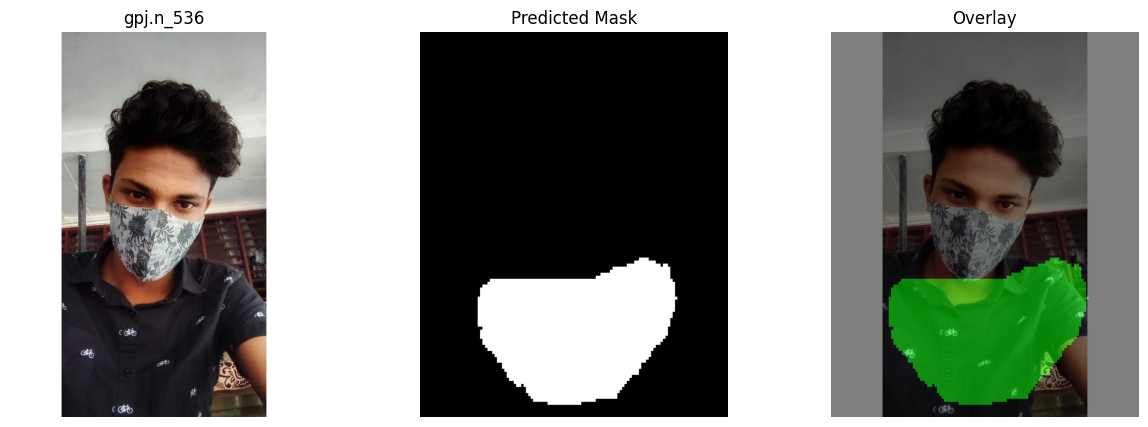

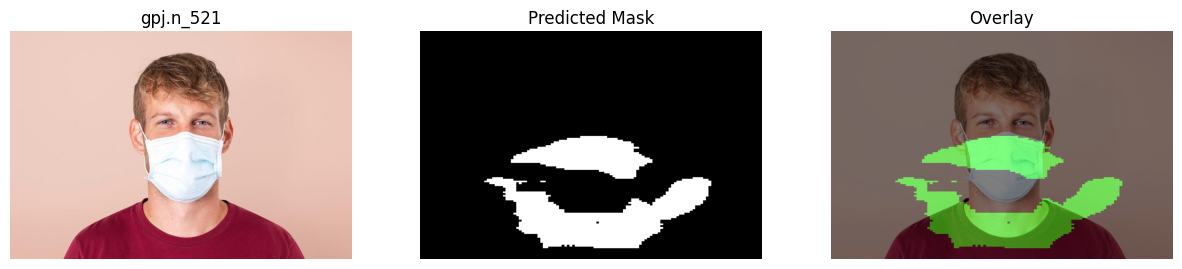

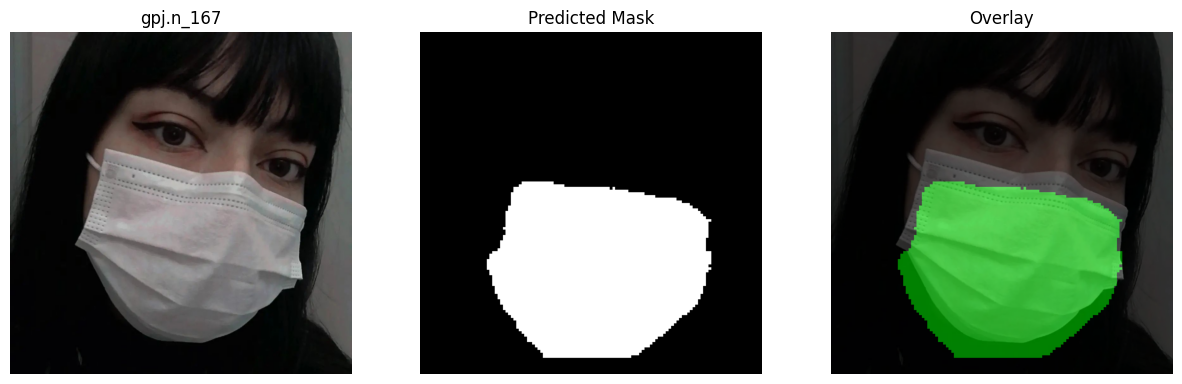

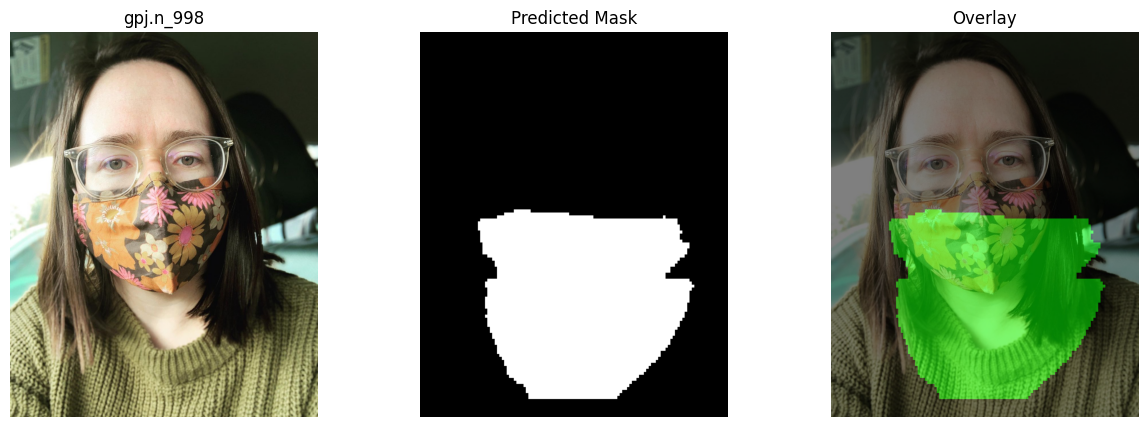

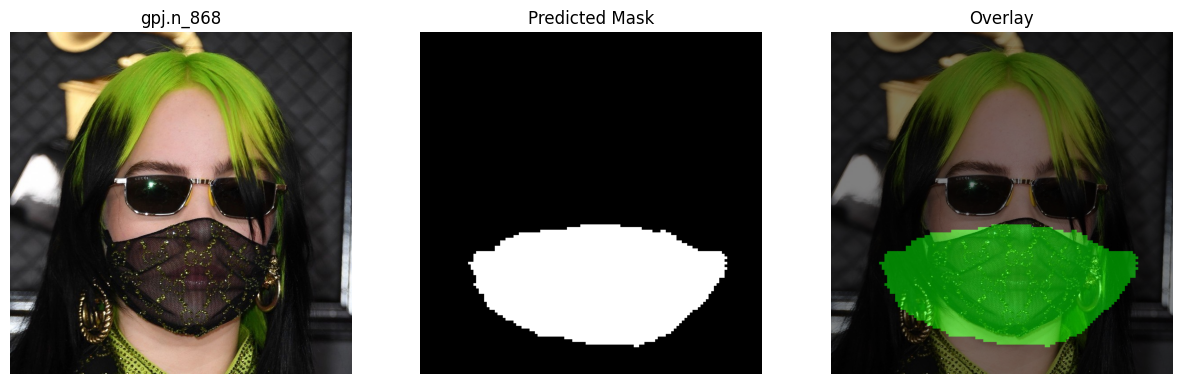

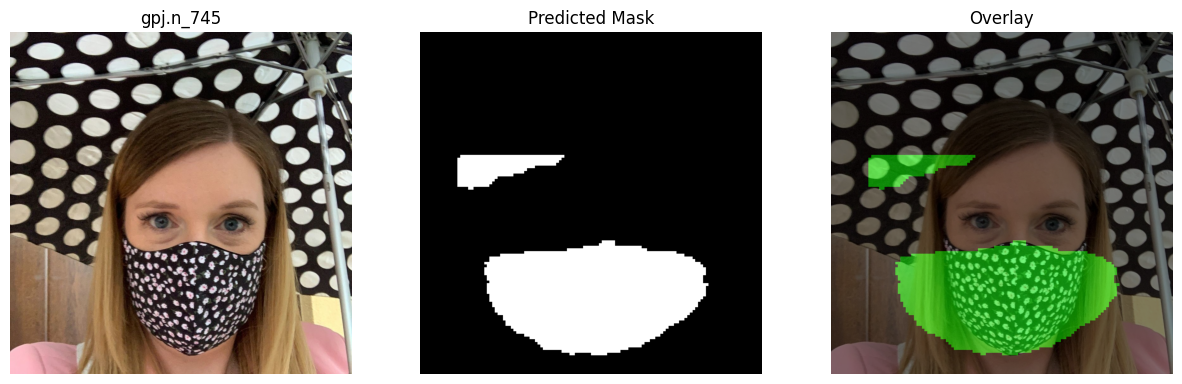

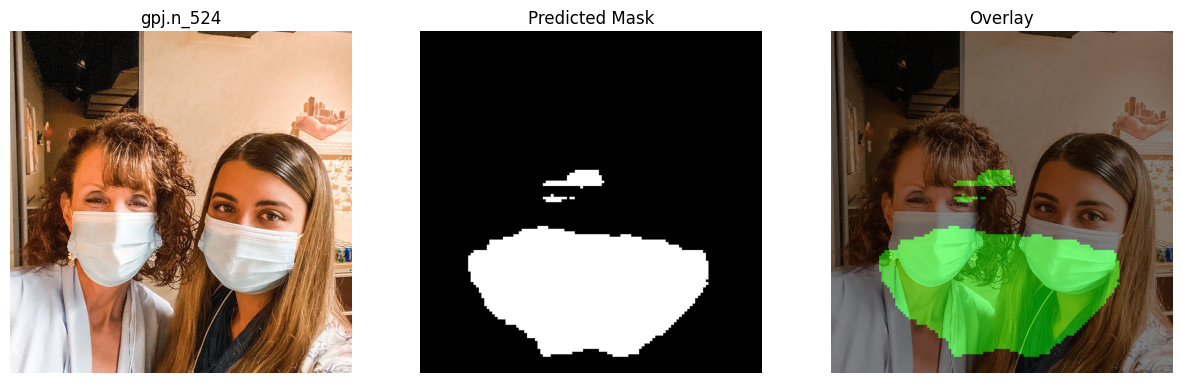

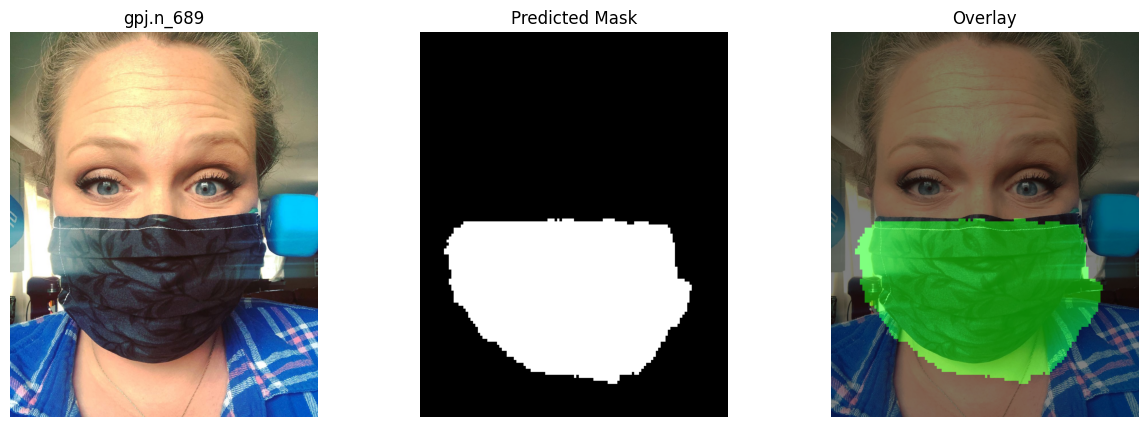

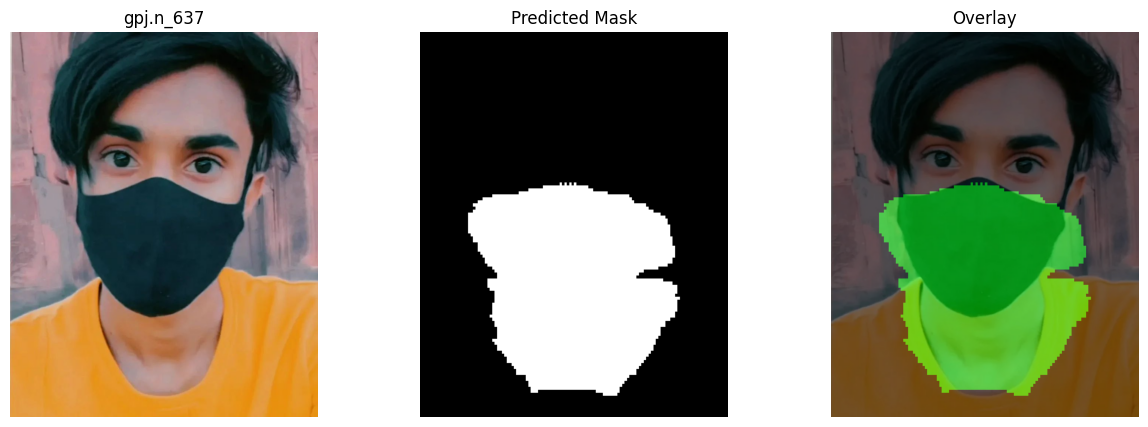

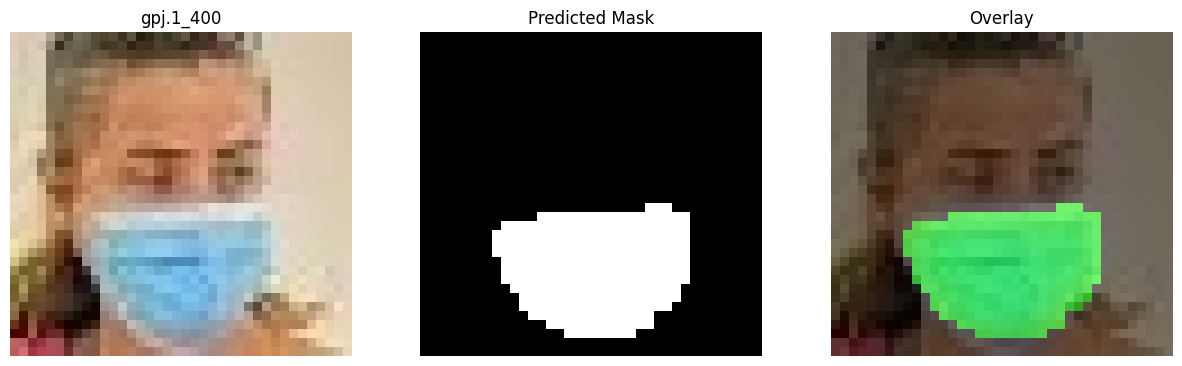

In [35]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

# Define the same UNet architecture
class FastUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(FastUNet, self).__init__()
        
        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, 3, padding=1),
                nn.ReLU(inplace=True)
            )
        
        self.enc1 = conv_block(in_channels, 32)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = conv_block(32, 64)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = conv_block(64, 128)
        self.pool3 = nn.MaxPool2d(2)
        
        self.bottleneck = conv_block(128, 256)
        
        self.upconv3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec3 = conv_block(256, 128)
        
        self.upconv2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec2 = conv_block(128, 64)
        
        self.upconv1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec1 = conv_block(64, 32)
        
        self.final = nn.Conv2d(32, out_channels, 1)
        
    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))
        enc3 = self.enc3(self.pool2(enc2))
        
        # Bottleneck
        bottleneck = self.bottleneck(self.pool3(enc3))
        
        # Decoder
        dec3 = self.upconv3(bottleneck)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)
        
        return self.final(dec1)

# Function to perform inference
def perform_inference(model, image_path, device, input_size=128):
    # Create the same transforms used during training
    transform = transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    original_image = image.copy()
    
    # Keep original dimensions for later resizing the mask
    original_size = image.size
    
    # Apply transforms
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Perform inference
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        pred_mask = torch.sigmoid(output) > 0.65
    
    # Convert the mask to a numpy array and resize to original dimensions
    pred_mask = pred_mask.squeeze().cpu().numpy().astype(np.uint8) * 255
    pred_mask_image = Image.fromarray(pred_mask)
    pred_mask_image = pred_mask_image.resize(original_size, Image.NEAREST)
    
    return original_image, pred_mask_image

# Set up the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Path to your custom image 
# This assumes you've uploaded your test image to Kaggle's input folder
custom_dataset_path = "/kaggle/input/test-images-for-mask-detection-unet-model"
import glob
all_files=glob.glob(custom_dataset_path+'/*.jpg')

custom_img_list = all_files[:10]
print(custom_img_list)
model = FastUNet().to(device)

# Load either the best model or final model
model_path = '/kaggle/input/test-images-for-mask-detection-unet-model/best_model.pth'  # or use 'final_model.pth'

# Handle both DataParallel and non-DataParallel saved models
state_dict = torch.load(model_path, map_location=device)
if list(state_dict.keys())[0].startswith('module.'):
    # Model was saved with DataParallel wrapper
    model = nn.DataParallel(model)
    model.load_state_dict(state_dict)
else:
    # Model was saved without DataParallel
    model.load_state_dict(state_dict)

# Perform inference
for custom_img in custom_img_list:
    original_image, pred_mask = perform_inference(model, custom_img, device)
    
    # Create a blended visualization
    original_array = np.array(original_image)
    mask_array = np.array(pred_mask)
    
    # Create RGB mask for overlay
    mask_rgb = np.zeros_like(original_array)
    mask_rgb[:,:,1] = mask_array  # Green channel for the mask
    
    # Blend the images (50% original, 50% mask)
    alpha = 0.5
    blended = (original_array * alpha + mask_rgb * (1-alpha)).astype(np.uint8)
    
    # Plot the results
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.title(custom_img[-1:-10:-1])
    plt.imshow(original_image)
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.title("Predicted Mask")
    plt.imshow(pred_mask, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.title("Overlay")
    plt.imshow(blended)
    plt.axis('off')

# plt.tight_layout()
# plt.savefig('/kaggle/working/inference_result.png')
# plt.show()

# print("Inference completed and visualization saved to 'inference_result.png'")



### Trying to Improve on Prev Unet
- Incorporated K-fold validation